In [1]:
%load_ext autoreload
%autoreload 2

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from config import FILE_PATHS
from preprocessing.preprocessor import Preprocessor

preprocessor = Preprocessor(file_paths=FILE_PATHS)

## Exploring ICU Patetients

In [12]:
icu_stays_df = preprocessor.preprocess_table('icu_stays')

icu_stays_df.head()

,subject_id,hadm_id,stay_id,first_careunit,last_careunit,intime,outtime,los
0,10000032,29079034,39553978,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2180-07-23 14:00:00,2180-07-23 23:50:47,0.410266
1,10000690,25860671,37081114,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2150-11-02 19:37:00,2150-11-06 17:03:17,3.893252
2,10000980,26913865,39765666,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2189-06-27 08:42:00,2189-06-27 20:38:27,0.497535
3,10001217,24597018,37067082,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU),2157-11-20 19:18:02,2157-11-21 22:08:00,1.118032
4,10001217,27703517,34592300,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU),2157-12-19 15:42:24,2157-12-20 14:27:41,0.948113


In [21]:
patients_df = preprocessor.preprocess_table('patients')
patients_df.head()

,subject_id,gender,anchor_age,anchor_year,anchor_year_group,dod,is_dead
0,10000032,F,52,2180,2014 - 2016,2180-09-09,True
1,10000048,F,23,2126,2008 - 2010,NaT,False
2,10000058,F,33,2168,2020 - 2022,NaT,False
3,10000068,F,19,2160,2008 - 2010,NaT,False
4,10000084,M,72,2160,2017 - 2019,2161-02-13,True


In [65]:
admission_df = preprocessor.preprocess_table('admissions')
admission_df.head()

,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admission_location,discharge_location,insurance,language,marital_status,race,edregtime,edouttime,hospital_expire_flag,admission_los_hours,is_dead
0,10000032,22595853,2180-05-06 22:23:00,2180-05-07 17:15:00,NaT,URGENT,TRANSFER FROM HOSPITAL,HOME,Medicaid,English,WIDOWED,White/European Descent,2180-05-06 19:17:00,2180-05-06 23:30:00,0,18.866667,False
1,10000032,22841357,2180-06-26 18:27:00,2180-06-27 18:49:00,NaT,EW EMER.,EMERGENCY ROOM,HOME,Medicaid,English,WIDOWED,White/European Descent,2180-06-26 15:54:00,2180-06-26 21:31:00,0,24.366667,False
2,10000032,25742920,2180-08-05 23:44:00,2180-08-07 17:50:00,NaT,EW EMER.,EMERGENCY ROOM,HOSPICE,Medicaid,English,WIDOWED,White/European Descent,2180-08-05 20:58:00,2180-08-06 01:44:00,0,42.100000,False
3,10000032,29079034,2180-07-23 12:35:00,2180-07-25 17:55:00,NaT,EW EMER.,EMERGENCY ROOM,HOME,Medicaid,English,WIDOWED,White/European Descent,2180-07-23 05:54:00,2180-07-23 14:00:00,0,53.333333,False
4,10000068,25022803,2160-03-03 23:16:00,2160-03-04 06:26:00,NaT,EU OBSERVATION,EMERGENCY ROOM,Unknown,Medicare,English,SINGLE,White/European Descent,2160-03-03 21:55:00,2160-03-04 06:26:00,0,7.166667,False


In [13]:
# read pickle file
import pickle

hosp_diagnosis_cause_df = pickle.load(open("../Processed_Data/hosp_diagnosis.pkl", "rb"))

# print the first 10 rows
hosp_diagnosis_cause_df.head(10)

,subject_id,hadm_id,icd_code,icd_version,category_code,category,subcategory
0,10000032,22595853,5723,9,572,Digestive System,Other Diseases Of Digestive System
1,10000032,22595853,78959,9,789,Symptoms & Abnormal Findings,Symptoms
2,10000032,22595853,5715,9,571,Digestive System,Other Diseases Of Digestive System
3,10000032,22595853,07070,9,070,Other,Other
4,10000032,22595853,496,9,496,Respiratory System,Chronic Obstructive Pulmonary Disease And Alli...
5,10000032,22595853,29680,9,296,Mental & Behavioral,Other Psychoses
6,10000032,22595853,30981,9,309,Mental & Behavioral,"Neurotic Disorders, Personality Disorders, And..."
7,10000032,22595853,V1582,9,V15,Other,Other
8,10000032,22841357,07071,9,070,Other,Other
9,10000032,22841357,78959,9,789,Symptoms & Abnormal Findings,Symptoms


In [72]:
# merge on subject_id and hadm_id
diagnosis_icu_df = hosp_diagnosis_cause_df.merge(icu_stays_df, on=['subject_id', 'hadm_id'], how='inner')
# merge with patients table to get demographics
diagnosis_icu_df = diagnosis_icu_df.merge(patients_df, on='subject_id', how='inner')
# merge with admission for insurance data
diagnosis_icu_df = diagnosis_icu_df.merge(admission_df.drop('is_dead', axis=1), on=['subject_id', 'hadm_id'], how='inner')

diagnosis_icu_df.head()

,subject_id,hadm_id,icd_code,icd_version,category_code,category,subcategory,stay_id,first_careunit,last_careunit,...,admission_location,discharge_location,insurance,language,marital_status,race,edregtime,edouttime,hospital_expire_flag,admission_los_hours
0,10000032,29079034,45829,9,458,Circulatory System,"Diseases Of Veins And Lymphatics, And Other Di...",39553978,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),...,EMERGENCY ROOM,HOME,Medicaid,English,WIDOWED,White/European Descent,2180-07-23 05:54:00,2180-07-23 14:00:00,0,53.333333
1,10000032,29079034,07044,9,070,Other,Other,39553978,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),...,EMERGENCY ROOM,HOME,Medicaid,English,WIDOWED,White/European Descent,2180-07-23 05:54:00,2180-07-23 14:00:00,0,53.333333
2,10000032,29079034,7994,9,799,Symptoms & Abnormal Findings,Ill-Defined And Unknown Causes Of Morbidity An...,39553978,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),...,EMERGENCY ROOM,HOME,Medicaid,English,WIDOWED,White/European Descent,2180-07-23 05:54:00,2180-07-23 14:00:00,0,53.333333
3,10000032,29079034,2761,9,276,Endocrine & Metabolic,Other Metabolic Disorders And Immunity Disorders,39553978,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),...,EMERGENCY ROOM,HOME,Medicaid,English,WIDOWED,White/European Descent,2180-07-23 05:54:00,2180-07-23 14:00:00,0,53.333333
4,10000032,29079034,78959,9,789,Symptoms & Abnormal Findings,Symptoms,39553978,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),...,EMERGENCY ROOM,HOME,Medicaid,English,WIDOWED,White/European Descent,2180-07-23 05:54:00,2180-07-23 14:00:00,0,53.333333


In [73]:
# break down of icu admissions by cause
diagnosis_icu_df.groupby('category').size().sort_values(ascending=False)

/var/folders/l5/2h1t38ld23b0fmqx49g_q67c0000gn/T/ipykernel_56166/87096069.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  diagnosis_icu_df.groupby('category').size().sort_values(ascending=False)


category
Other                           346293
Circulatory System              267127
Endocrine & Metabolic           160151
Symptoms & Abnormal Findings    118081
Digestive System                106167
Respiratory System              100904
Health Factors & Services        96313
Blood & Immune System            86105
Genitourinary System             84258
Nervous System                   78657
Mental & Behavioral              78454
Injury & Poisoning               75200
Musculoskeletal & Connective     41579
External Causes                  38091
Neoplasms                        29125
Infectious & Parasitic           19048
Skin & Subcutaneous              17477
Eye & Adnexa                      5982
Congenital & Chromosomal          4582
Pregnancy & Childbirth            2907
Special Purposes                  1381
Ear & Mastoid                     1354
Perinatal Conditions                 6
dtype: int64

In [74]:
# save to pickle file
diagnosis_icu_df.to_pickle("../Processed_Data/diagnosis_icu_df.pkl")

/var/folders/l5/2h1t38ld23b0fmqx49g_q67c0000gn/T/ipykernel_56166/1588128893.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  respiratory_counts = respiratory_df.groupby('anchor_year_group').size()


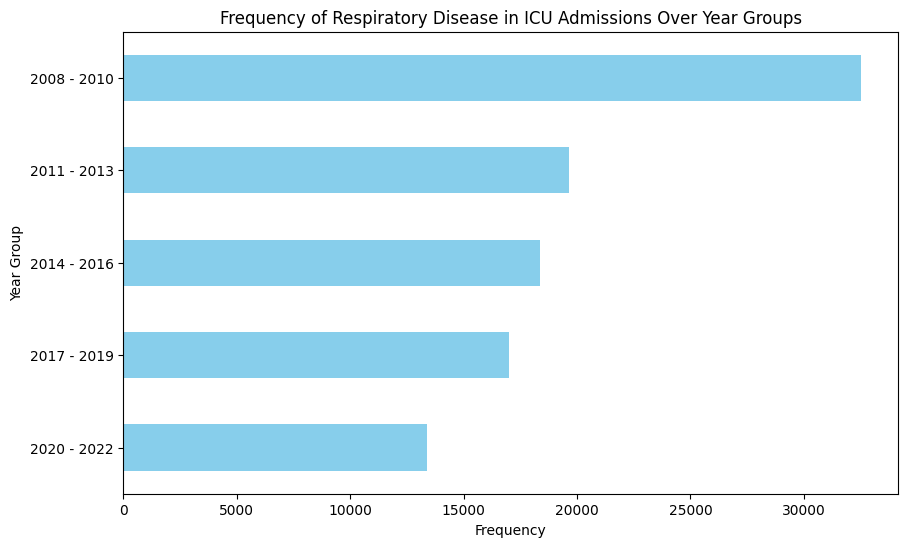

In [75]:
# Filter the dataframe for respiratory disease
respiratory_df = diagnosis_icu_df[diagnosis_icu_df['category'] == 'Respiratory System']

# Group by anchor_year_group and count occurrences
respiratory_counts = respiratory_df.groupby('anchor_year_group').size()

# Plotting
plt.figure(figsize=(10, 6))
respiratory_counts.sort_values().plot(kind='barh', color='skyblue')
plt.xlabel('Frequency')
plt.ylabel('Year Group')
plt.title('Frequency of Respiratory Disease in ICU Admissions Over Year Groups')
plt.show()

Isolating COVID-19 patients by icd code

Confirmed—A confirmed COVID-19 hospital encounter is defined as any listed ICD–10–CM diagnosis code of B97.29 and/or U07.1. Prior to April 1, 2020, CDC guidance stated to code a confirmed COVID-19 hospital encounter as B97.29. On April 1, 2020, the guidance changed to code confirmed COVID-19 hospital encounters as U07.1. The figure shows the percentage of hospital encounters coded with a B97.29 and/or U07.1 code. 

Suspected—A suspected COVID-19 hospital encounter in 2020 is defined by an ICD–10–CM code of contact with and (suspected) exposure to other viral communicable diseases (Z20.828) and in 2021 it is defined by an ICD-10-CM code of contact with and (suspected) exposure to COVID-19 (Z20.822). Additionally, suspected encounters do not contain any confirmed codes. In early versions (March 18, 2020 – December 29, 2020) of this figure, suspected COVID-19 was defined by the ICD-10-CM code for COVID-19, virus not identified (U07.2) or coronavirus infection, unspecified (B34.2). Also, the earlier version included potential COVID-19 hospital encounters as having an ICD–10–CM code for pneumonia (J12.89), acute bronchitis (J20.8, J40), lower respiratory infection (J22, J98.8), or Acute Respiratory Distress Syndrome (J80). The potential portion of the definition was removed for this update due to revised CDC guidance for coding suspected COVID-19. See the related links below for coding guidelines.

/var/folders/l5/2h1t38ld23b0fmqx49g_q67c0000gn/T/ipykernel_56166/2295120673.py:8: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  covid_diagnoses = diagnosis_icu_df[diagnosis_icu_df['icd_code'].str.contains(covid_pattern, regex=True, na=False)]
/var/folders/l5/2h1t38ld23b0fmqx49g_q67c0000gn/T/ipykernel_56166/2295120673.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  covid_diagnoses['covid_category'] = 'Other'
/var/folders/l5/2h1t38ld23b0fmqx49g_q67c0000gn/T/ipykernel_56166/2295120673.py:12: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  covid_diagnoses.loc[covid_diagnos

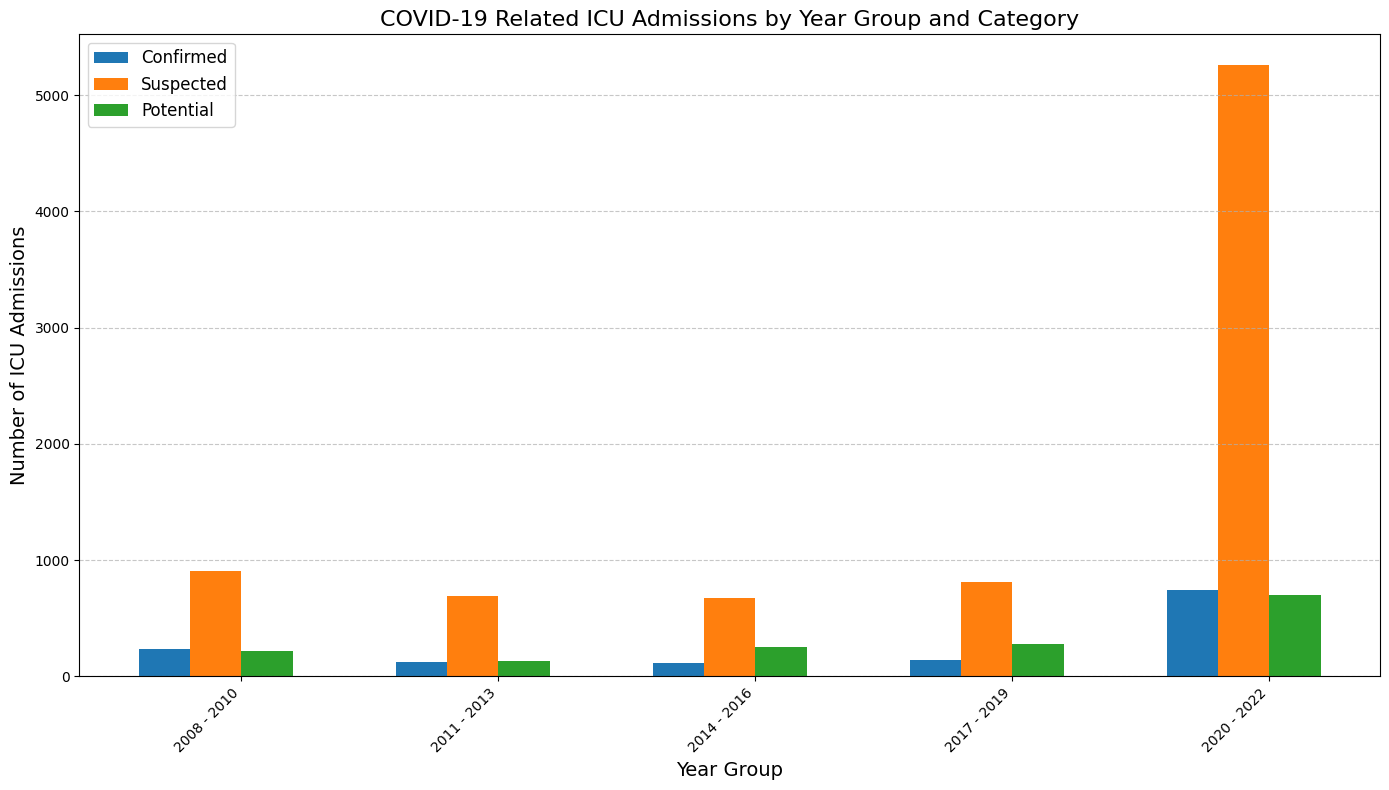

covid_category
Confirmed    1367
Potential    1588
Suspected    8339
dtype: int64


In [76]:
# Define COVID-19 related ICD-10-CM codes
covid_codes = ['U071', 'B9729', 'Z20828', 'Z20822', 'J1289', 'J208', 'J40', 'J22', 'J988', 'J80']

# Create a regex pattern to match the codes at the start of the string
covid_pattern = '^(' + '|'.join(covid_codes) + ')'

# Filter the dataframe for COVID-19 diagnoses using the defined codes with contains
covid_diagnoses = diagnosis_icu_df[diagnosis_icu_df['icd_code'].str.contains(covid_pattern, regex=True, na=False)]

# Create a new column to categorize the diagnosis
covid_diagnoses['covid_category'] = 'Other'
covid_diagnoses.loc[covid_diagnoses['icd_code'].str.contains('^(U071|B9729)', regex=True, na=False), 'covid_category'] = 'Confirmed'
covid_diagnoses.loc[covid_diagnoses['icd_code'].str.contains('^(Z20828|Z20822)', regex=True, na=False), 'covid_category'] = 'Suspected'
covid_diagnoses.loc[covid_diagnoses['icd_code'].str.contains('^(J1289|J208|J40|J22|J988|J80)', regex=True, na=False), 'covid_category'] = 'Potential'

# Group by anchor_year_group and covid_category, then count occurrences
covid_counts = covid_diagnoses.groupby(['anchor_year_group', 'covid_category']).size().unstack(fill_value=0)

# Sort the year groups in chronological order
covid_counts = covid_counts.sort_index(key=lambda x: x.str.split(' - ').str[0].astype(int))

# Plotting
plt.figure(figsize=(14, 8))
bar_width = 0.2
index = np.arange(len(covid_counts.index))

for i, category in enumerate(['Confirmed', 'Suspected', 'Potential']):
    if category in covid_counts.columns:
        plt.bar(index + i*bar_width, covid_counts[category], bar_width, label=category)

plt.xlabel('Year Group', fontsize=14)
plt.ylabel('Number of ICU Admissions', fontsize=14)
plt.title('COVID-19 Related ICU Admissions by Year Group and Category', fontsize=16)
plt.xticks(index + bar_width * 1.5, covid_counts.index, rotation=45, ha='right')
plt.legend(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# Print total counts for each category
print(covid_counts.sum())

/var/folders/l5/2h1t38ld23b0fmqx49g_q67c0000gn/T/ipykernel_56166/2647748004.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mortality_data = covid_diagnoses.groupby('anchor_year_group').agg({


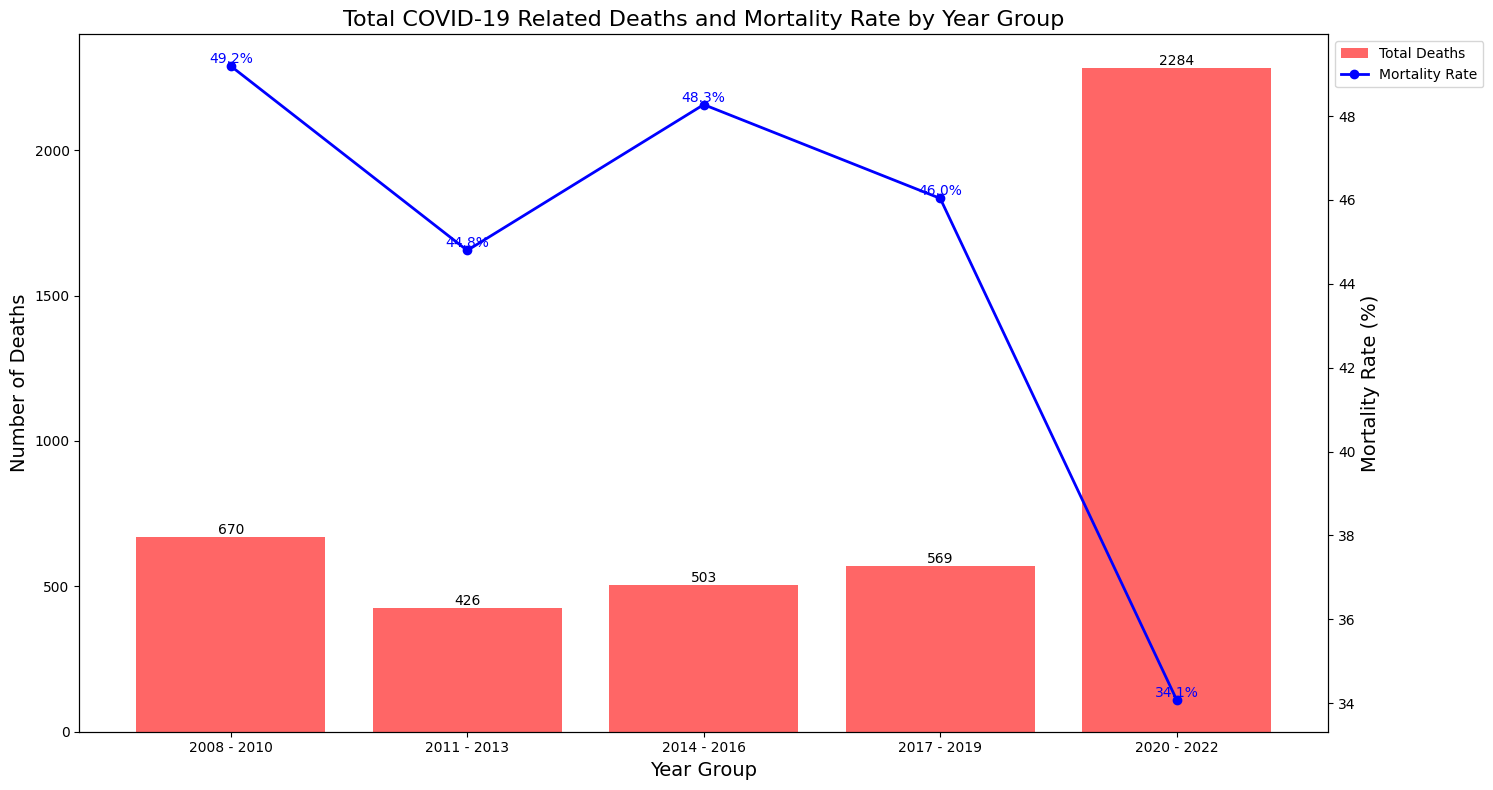

In [77]:
# Group by anchor_year_group and calculate total deaths and mortality rate
mortality_data = covid_diagnoses.groupby('anchor_year_group').agg({
    'is_dead': ['count', 'sum']
})

mortality_data.columns = ['total_patients', 'deaths']
mortality_data['mortality_rate'] = mortality_data['deaths'] / mortality_data['total_patients'] * 100

# Sort the year groups in chronological order
mortality_data = mortality_data.sort_index(key=lambda x: x.str.split(' - ').str[0].astype(int))

# Plotting
fig, ax1 = plt.subplots(figsize=(14, 8))

# Bar plot for total deaths
ax1.bar(mortality_data.index, mortality_data['deaths'], alpha=0.6, color='red', label='Total Deaths')
ax1.set_xlabel('Year Group', fontsize=14)
ax1.set_ylabel('Number of Deaths', fontsize=14)
ax1.tick_params(axis='y')

# Line plot for mortality rate
ax2 = ax1.twinx()
ax2.plot(mortality_data.index, mortality_data['mortality_rate'], color='blue', marker='o', linewidth=2, label='Mortality Rate')
ax2.set_ylabel('Mortality Rate (%)', fontsize=14)
ax2.tick_params(axis='y')

# Title and legend
plt.title('Total COVID-19 Related Deaths and Mortality Rate by Year Group', fontsize=16)
fig.legend(loc='upper left', bbox_to_anchor=(1, 1), bbox_transform=ax1.transAxes)

# Rotate x-axis labels
plt.xticks(rotation=45, ha='right')

# Add value labels
for i, (deaths, rate) in enumerate(zip(mortality_data['deaths'], mortality_data['mortality_rate'])):
    ax1.text(i, deaths, f'{deaths}', ha='center', va='bottom')
    ax2.text(i, rate, f'{rate:.1f}%', ha='center', va='bottom', color='blue')

plt.tight_layout()
plt.show()

Exploring Insurance Distribution

/var/folders/l5/2h1t38ld23b0fmqx49g_q67c0000gn/T/ipykernel_56166/1436473776.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  insurance_counts = covid_diagnoses.groupby('insurance').size().sort_values(ascending=False)


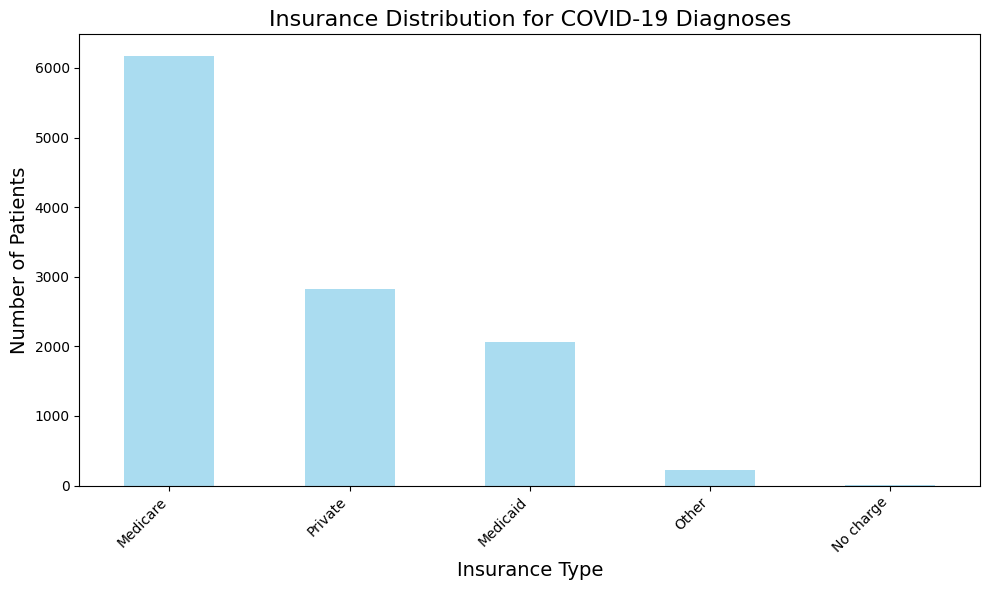

In [81]:
insurance_counts = covid_diagnoses.groupby('insurance').size().sort_values(ascending=False)

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
insurance_counts.plot(kind='bar', ax=ax, color='skyblue', alpha=0.7)

# Title and labels
ax.set_title('Insurance Distribution for COVID-19 Diagnoses', fontsize=16)
ax.set_xlabel('Insurance Type', fontsize=14)
ax.set_ylabel('Number of Patients', fontsize=14)

# Rotate x-axis labels
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

/var/folders/l5/2h1t38ld23b0fmqx49g_q67c0000gn/T/ipykernel_56166/1306561847.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  covid_diagnoses['age_group'] = pd.cut(covid_diagnoses['anchor_age'],


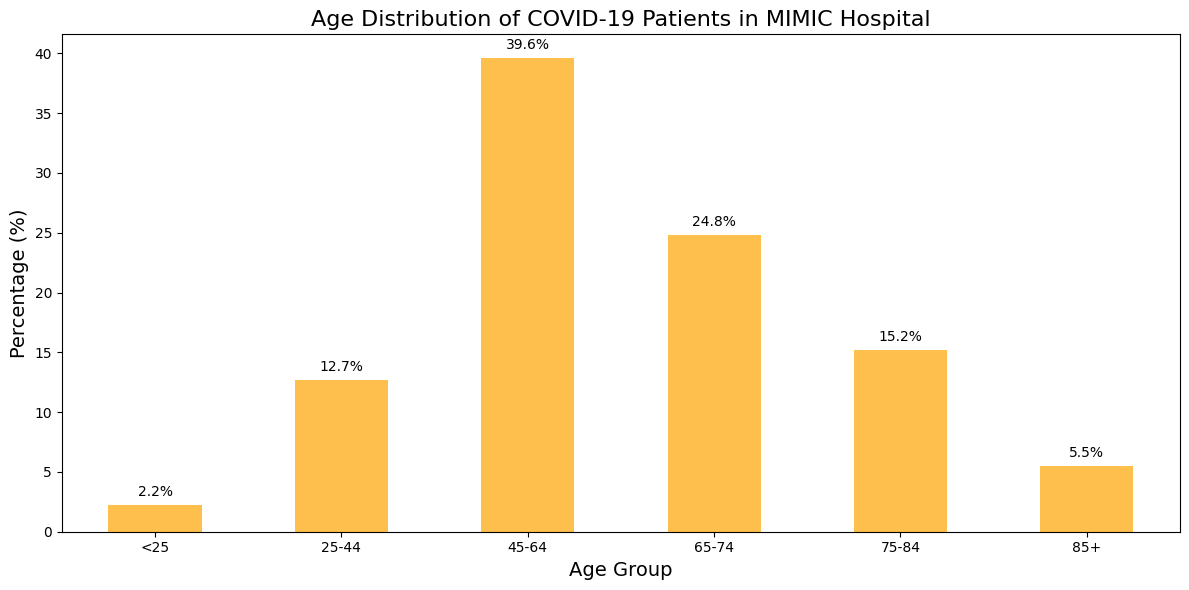

age_group
<25       2.195856
25-44    12.697007
45-64    39.605100
65-74    24.783071
75-84    15.202763
85+       5.516203
Name: proportion, dtype: float64


In [82]:
# Create age groups for COVID-19 patients
covid_diagnoses['age_group'] = pd.cut(covid_diagnoses['anchor_age'], 
                                      bins=[0, 25, 45, 65, 75, 85, 100],
                                      labels=['<25', '25-44', '45-64', '65-74', '75-84', '85+'])

# Calculate the percentage distribution
age_distribution = covid_diagnoses['age_group'].value_counts(normalize=True).sort_index() * 100

# Plotting
plt.figure(figsize=(12, 6))
age_distribution.plot(kind='bar', color='orange', alpha=0.7)

plt.title('Age Distribution of COVID-19 Patients in MIMIC Hospital', fontsize=16)
plt.xlabel('Age Group', fontsize=14)
plt.ylabel('Percentage (%)', fontsize=14)
plt.xticks(rotation=0)

# Add percentage labels on top of each bar
for i, v in enumerate(age_distribution):
    plt.text(i, v + 0.5, f'{v:.1f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Print the distribution
print(age_distribution)

In [83]:
# load suffolk_df

import pickle

suffolk_df = pickle.load(open("../Processed_Data/suffolk_df.pkl", "rb"))

,YEAR,MONTH,BENE_GEO_LVL,BENE_STATE_ABRVTN,BENE_STATE_DESC,BENE_COUNTY_DESC,BENE_FIPS_CD,TOT_BENES,ORGNL_MDCR_BENES,MA_AND_OTH_BENES,...,B_TOT_BENES_PCT,B_ORGNL_MDCR_BENES_PCT,B_MA_AND_OTH_BENES_PCT,PRSCRPTN_DRUG_TOT_BENES_PCT,PRSCRPTN_DRUG_PDP_BENES_PCT,PRSCRPTN_DRUG_MAPD_BENES_PCT,PRSCRPTN_DRUG_DEEMED_ELIGIBLE_FULL_LIS_BENES_PCT,PRSCRPTN_DRUG_FULL_LIS_BENES_PCT,PRSCRPTN_DRUG_PARTIAL_LIS_BENES_PCT,PRSCRPTN_DRUG_NO_LIS_BENES_PCT
1273,2013,Year,County,MA,Massachusetts,Suffolk County,25025,96914.0,81999.0,14914.0,...,5.564784,4.608062,0.956722,4.345382,3.409192,0.936126,2.702382,0.081358,0.048763,1.512880
4608,2013,January,County,MA,Massachusetts,Suffolk County,25025,95608.0,81363.0,14245.0,...,5.567345,4.641048,0.926297,4.344877,3.440171,0.904706,2.655846,0.088578,0.052549,1.547905
7943,2013,February,County,MA,Massachusetts,Suffolk County,25025,95724.0,81411.0,14313.0,...,5.565119,4.635521,0.929599,4.346052,3.437761,0.908291,2.664590,0.087828,0.052099,1.541536
11278,2013,March,County,MA,Massachusetts,Suffolk County,25025,95973.0,81600.0,14373.0,...,5.564164,4.632882,0.931281,4.339261,3.429041,0.910220,2.674801,0.086058,0.050741,1.527661
14613,2013,April,County,MA,Massachusetts,Suffolk County,25025,96181.0,81691.0,14490.0,...,5.562496,4.625703,0.936792,4.344110,3.428267,0.915843,2.682609,0.083929,0.048818,1.528754
17948,2013,May,County,MA,Massachusetts,Suffolk County,25025,96445.0,81872.0,14573.0,...,5.559221,4.619343,0.939878,4.343591,3.424419,0.919173,2.693983,0.082306,0.048958,1.518344
21283,2013,June,County,MA,Massachusetts,Suffolk County,25025,96748.0,82065.0,14683.0,...,5.556731,4.612678,0.944053,4.343674,3.420135,0.923539,2.700777,0.081544,0.048425,1.512929
24618,2013,July,County,MA,Massachusetts,Suffolk County,25025,97038.0,82249.0,14789.0,...,5.570031,4.622979,0.947052,4.344359,3.417675,0.926684,2.708187,0.080127,0.047782,1.508263
27953,2013,August,County,MA,Massachusetts,Suffolk County,25025,97340.0,82441.0,14899.0,...,5.568513,4.617234,0.951279,4.345741,3.414643,0.931098,2.715697,0.078874,0.047899,1.503271
31288,2013,September,County,MA,Massachusetts,Suffolk County,25025,97525.0,82520.0,15005.0,...,5.569136,4.612986,0.956149,4.347258,3.411186,0.936072,2.722358,0.078017,0.047868,1.499015


/var/folders/l5/2h1t38ld23b0fmqx49g_q67c0000gn/T/ipykernel_56166/4259004.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  covid_diagnoses['age_group'] = pd.cut(covid_diagnoses['anchor_age'], bins=bins, labels=age_labels, right=False)


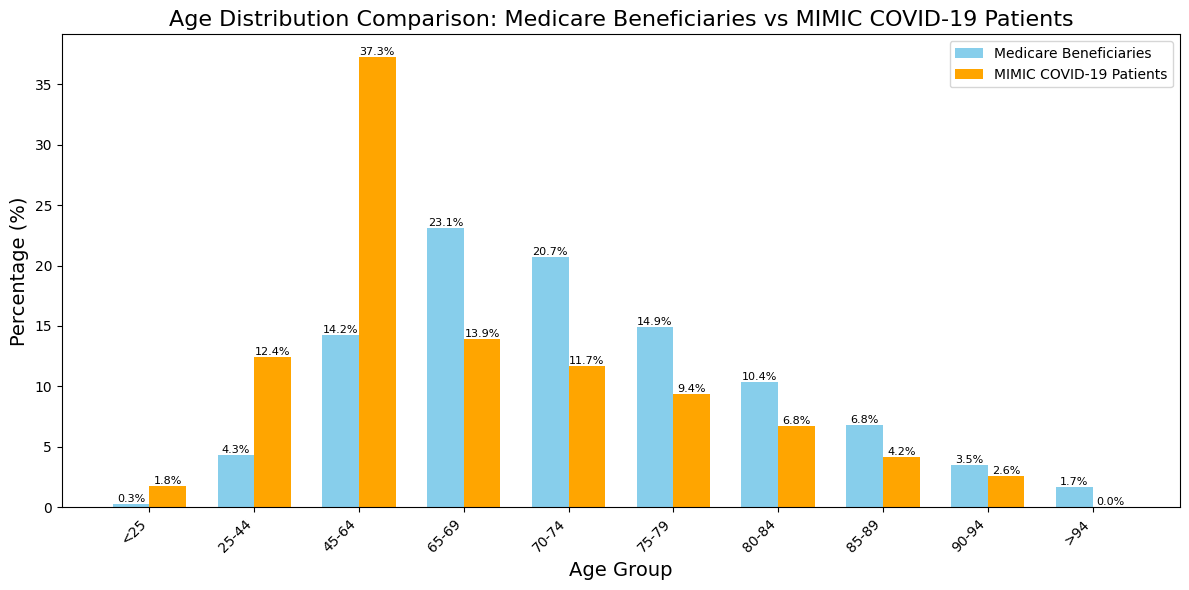

Medicare Beneficiaries Age Distribution:
<25       0.28
25-44     4.29
45-64    14.24
65-69    23.08
70-74    20.71
75-79    14.95
80-84    10.39
85-89     6.85
90-94     3.53
>94       1.67
dtype: float64

MIMIC Hospital COVID-19 Patients Age Distribution:
age_group
<25       1.80
25-44    12.42
45-64    37.26
65-69    13.93
70-74    11.66
75-79     9.39
80-84     6.76
85-89     4.18
90-94     2.60
>94       0.00
Name: count, dtype: float64


In [85]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming suffolk_df is already loaded and covid_diagnoses is available

# Age Distribution Analysis for Medicare Beneficiaries
age_columns = [
    'AGE_LT_25_BENES', 'AGE_25_TO_44_BENES', 'AGE_45_TO_64_BENES',
    'AGE_65_TO_69_BENES', 'AGE_70_TO_74_BENES', 'AGE_75_TO_79_BENES',
    'AGE_80_TO_84_BENES', 'AGE_85_TO_89_BENES', 'AGE_90_TO_94_BENES',
    'AGE_GT_94_BENES'
]

age_distribution_medicare = suffolk_df[age_columns].sum()
total_beneficiaries = age_distribution_medicare.sum()
age_percentages_medicare = (age_distribution_medicare / total_beneficiaries * 100).round(2)

# Friendly labels for visualization
age_labels = [
    '<25', '25-44', '45-64', '65-69', '70-74', '75-79',
    '80-84', '85-89', '90-94', '>94'
]

age_percentages_medicare.index = age_labels

# For COVID-19 patients (assuming covid_diagnoses DataFrame exists)
bins = [0, 25, 45, 65, 70, 75, 80, 85, 90, 95, 150]
covid_diagnoses['age_group'] = pd.cut(covid_diagnoses['anchor_age'], bins=bins, labels=age_labels, right=False)

age_distribution_covid = covid_diagnoses['age_group'].value_counts().sort_index()
total_covid_patients = age_distribution_covid.sum()
age_percentages_covid = (age_distribution_covid / total_covid_patients * 100).round(2)

# Plotting
fig, ax = plt.subplots(figsize=(12, 6))

x = range(len(age_labels))
width = 0.35

ax.bar([i - width/2 for i in x], age_percentages_medicare, width, label='Medicare Beneficiaries', color='skyblue')
ax.bar([i + width/2 for i in x], age_percentages_covid, width, label='MIMIC COVID-19 Patients', color='orange')

ax.set_ylabel('Percentage (%)', fontsize=14)
ax.set_xlabel('Age Group', fontsize=14)
ax.set_title('Age Distribution Comparison: Medicare Beneficiaries vs MIMIC COVID-19 Patients', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(age_labels, rotation=45, ha='right')
ax.legend()

# Add percentage labels on top of each bar
for i, v in enumerate(age_percentages_medicare):
    ax.text(i - width/2, v, f'{v:.1f}%', ha='center', va='bottom', fontsize=8)
for i, v in enumerate(age_percentages_covid):
    ax.text(i + width/2, v, f'{v:.1f}%', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

# Print the distributions
print("Medicare Beneficiaries Age Distribution:")
print(age_percentages_medicare)
print("\nMIMIC Hospital COVID-19 Patients Age Distribution:")
print(age_percentages_covid)

## Exploring Prescriptions In Covid 

In [8]:
prescriptions_table = pd.read_csv(FILE_PATHS['prescriptions'], nrows=1000)

prescriptions_table

,subject_id,hadm_id,pharmacy_id,poe_id,poe_seq,order_provider_id,starttime,stoptime,drug_type,drug,...,gsn,ndc,prod_strength,form_rx,dose_val_rx,dose_unit_rx,form_val_disp,form_unit_disp,doses_per_24_hrs,route
0,10000032,22595853,12775705,10000032-55,55.0,P85UQ1,2180-05-08 08:00:00,2180-05-07 22:00:00,MAIN,Furosemide,...,8209.0,51079007320,40mg Tablet,NaN,40,mg,1,TAB,1.0,PO/NG
1,10000032,22595853,18415984,10000032-42,42.0,P23SJA,2180-05-07 02:00:00,2180-05-07 22:00:00,MAIN,Ipratropium Bromide Neb,...,21700.0,487980125,2.5mL Vial,NaN,1,NEB,1,VIAL,4.0,IH
2,10000032,22595853,23637373,10000032-35,35.0,P23SJA,2180-05-07 01:00:00,2180-05-07 09:00:00,MAIN,Furosemide,...,8208.0,51079007220,20mg Tablet,NaN,20,mg,1,TAB,1.0,PO/NG
3,10000032,22595853,26862314,10000032-41,41.0,P23SJA,2180-05-07 01:00:00,2180-05-07 01:00:00,MAIN,Potassium Chloride,...,1275.0,245004101,10mEq ER Tablet,NaN,40,mEq,4,TAB,1.0,PO
4,10000032,22595853,30740602,10000032-27,27.0,P23SJA,2180-05-07 00:00:00,2180-05-07 22:00:00,MAIN,Sodium Chloride 0.9% Flush,...,NaN,0,10 mL Syringe,NaN,3,mL,0.3,SYR,3.0,IV
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,10001176,23334588,20202240,10001176-53,53.0,P193M6,2186-11-29 10:00:00,2186-12-02 19:00:00,MAIN,Lisinopril,...,391.0,51079098320,20mg Tablet,NaN,20,mg,1,TAB,1.0,PO/NG
996,10001176,23334588,23260953,10001176-49,49.0,P193M6,2186-11-29 10:00:00,2186-12-02 19:00:00,MAIN,Levothyroxine Sodium,...,6648.0,74434113,25mcg Tablet,NaN,25,mcg,1,TAB,1.0,PO/NG
997,10001176,23334588,23677606,10001176-43,43.0,P193M6,2186-11-29 07:00:00,2186-12-02 19:00:00,MAIN,Glucagon,...,41660.0,55390000401,1mg Vial,NaN,1,mg,1,VIAL,NaN,IM
998,10001176,23334588,29613619,10001176-78,78.0,P70JO0,2186-11-30 16:00:00,2186-12-02 19:00:00,MAIN,Insulin,...,27413.0,0,Dummy Package for Sliding Scale,NaN,0,UNIT,0,VIAL,NaN,SC
